In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)  #문자열 변환
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


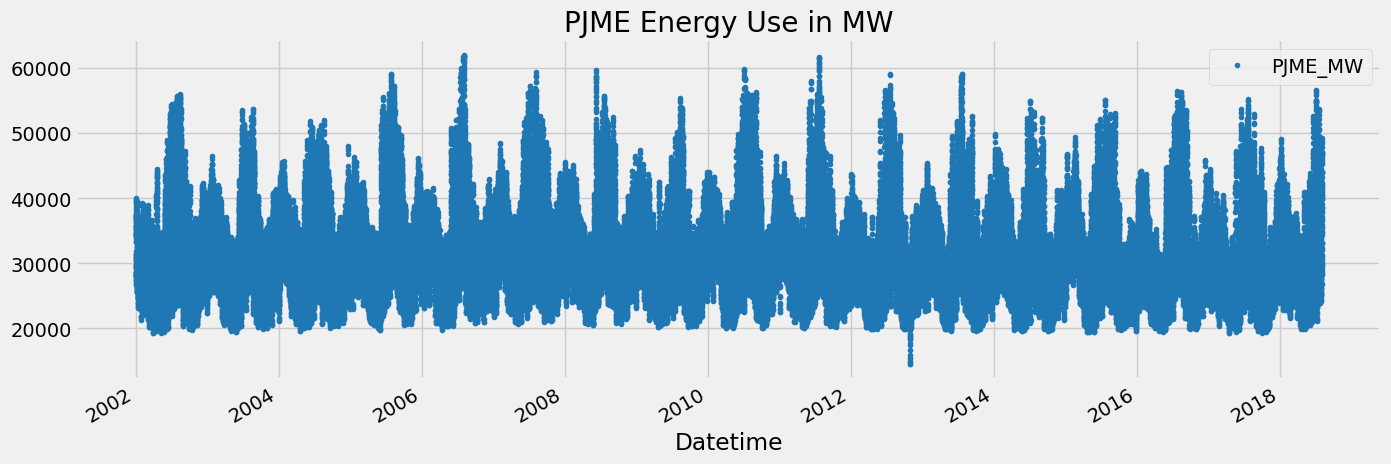

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')

plt.show()

# train/test split







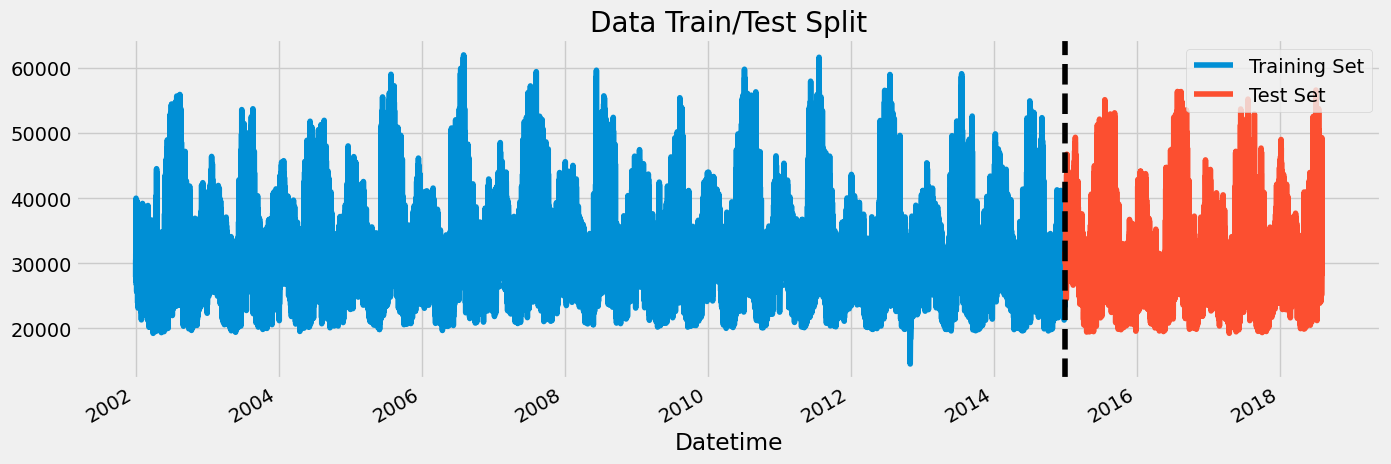

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# feature 만들기

In [5]:
#함수

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek  #월=0 화=1
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Feature / Target 변수의 관계 시각화

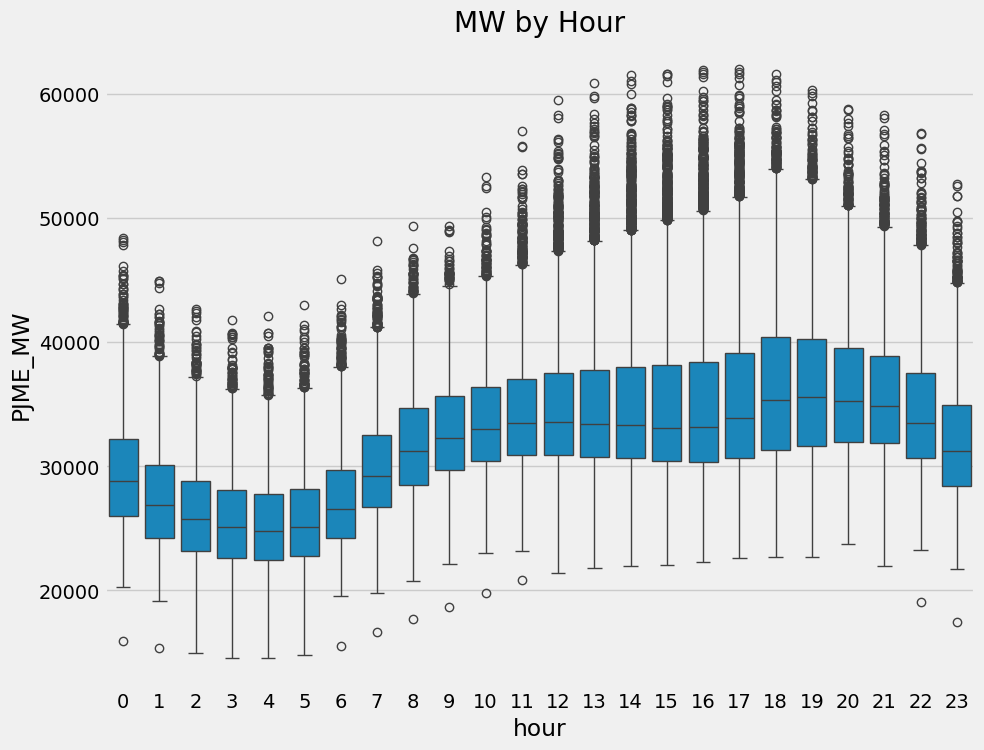

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')  #시간 당 메가와트
plt.show()

# 결과 = 아침에는 에너지 사용량 감소 , 저녁에는 사용량 증

/tmp/ipython-input-7-3417514029.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


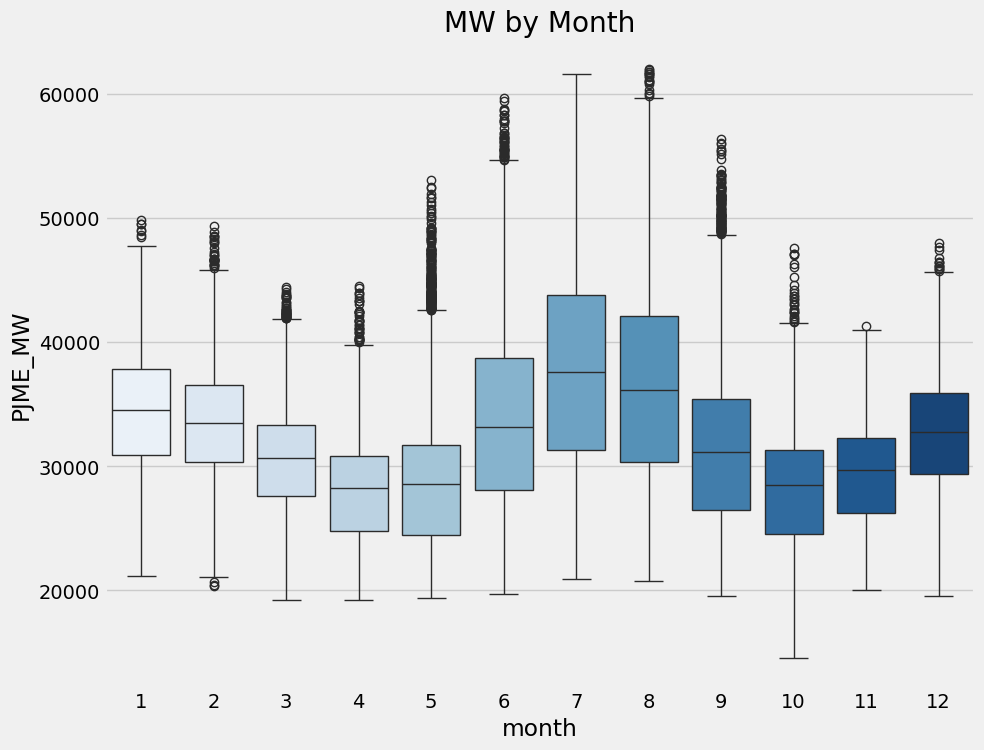

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')  #월별 메가와트
plt.show()

#결과 : 가을과 봄에는 사용량 낮아지다가 여름에 사용량 정점

# model 만들기

In [8]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [9]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,                   #강화된 트리 알고리즘이 트리의수
                       early_stopping_rounds=50,            #50개의 트리 이후에도 개선되지않으면 모델 중단(과적합을 줄이기 위해)
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)



[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:57:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# 특성 중요도 확인

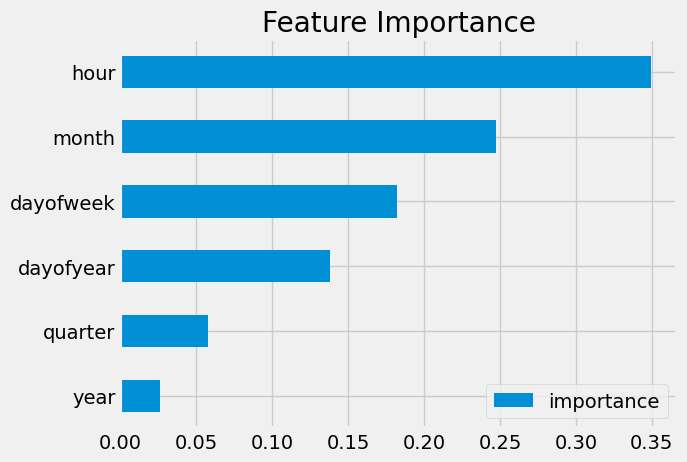

In [10]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# 변수들의 상관관계가 높은 경우 개별적으로 중요도를 알수 없기때문에
# 모델을 전체적으로 보는게 중

# test set  예측

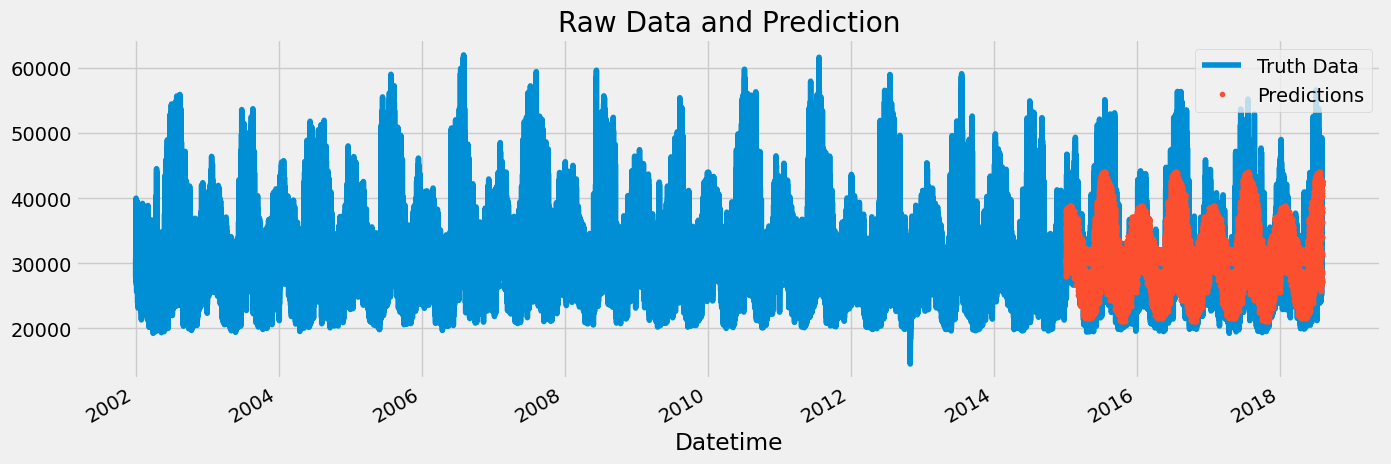

In [11]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

# rmse

In [15]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Test set: {score:0.2f}')

RMSE Test set: 3726.80


# 오차계산

In [16]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)  #날짜별로 그룹화 후 오차계산

#오차 큰 날 : 8월 중

,error
date,
2016-08-13,12879.484619
2016-08-14,12772.887207
2015-02-20,11186.031494
2016-09-09,10966.513102
2016-09-10,10889.102214
2018-01-06,10642.975830
2016-08-12,10041.172689
2015-02-21,9988.168783
2015-02-16,9900.809326


In [20]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

# 오차 작은 날 : 2017년 10월 24일

,error
date,
2017-10-24,322.958008
2015-10-28,426.451335
2016-10-27,543.167155
2015-05-06,556.749674
2017-10-15,569.468262
2018-05-16,569.951009
2015-11-06,678.310140
2017-04-07,687.475911
2016-12-29,706.143392
